### Bifurcation diagram for the autaptic neuron

For fixed autaptic parameters, what does the bifurcation diagram look like? 
The driving current at which bifurcations occur will likely be different.

Will also try varying other autaptic parameter values and fixing the injected current. What do these bifurcation diagrams look like?

In [1]:

#imports for AQUA
import sys
sys.path.append("..\\") # parent directory
from AQUA_class import AQUA
from plotting_functions import *


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style = "white")

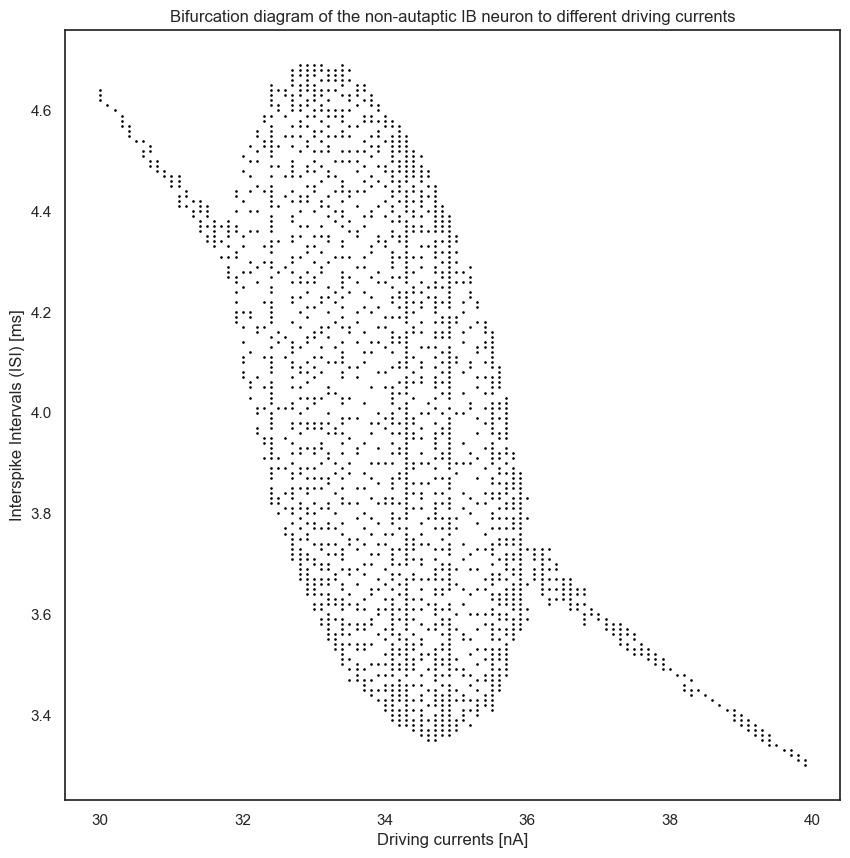

In [2]:
# Bifurcation diagram with autapse
# Different neurons will have different bifurcation diagrams. 
# Neurons are probably also defined by their early behaviour, not just their steady state.

# running the code below with a current step of 0.1 would take ~75 mins

# Will use the IB neuron of the izhikevich model
name = 'FS'
a = 0.1
b = 0.2
c = -65
d = 2

#autaptic params
e = 0.1
f = -7
tau = 5     # ms

# Define the neuron with autapse
neuron = AQUA(a, b, c, d, e, f, tau)

# Injected current values
dI = 0.1
I_vals = np.arange(3, 80, dI)

#Initial values to re-initialise neuron
x_start = np.array([c, 0, 0])
t_start = np.array([0])

# simulation parameters
T = 2500      # ms
dt = 0.01     # ms
N_iter = int(T/dt)

# dataframe to store variables for plotting
data_array = np.zeros((1, 3))


#define fig and ax
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

for i in tqdm(I_vals):
    I_inj = i*np.ones(N_iter) # constant current

    neuron.Initialise(x_start, t_start)

    X, T, spike_times = neuron.update_RK2(dt, N_iter, I_inj)
    
    #Only get the steady state ISI (last 20% of spikes)
    ISI = np.ediff1d(spike_times[-int(0.5*len(spike_times)):])
    isi_vals, isi_counts = np.unique(np.round(ISI, decimals = 6), return_counts = True)
    ax.scatter(i*np.ones(len(isi_vals)), isi_vals, c = 'black', s = 0.8, marker = "o")

    for j in range(len(isi_vals)):
        df_row = np.array([i, isi_vals[j], isi_counts[j]])
        data_array = np.vstack((data_array, df_row))

cols = ['I_ext', 'ISI_values', 'ISI_counts']
df = pd.DataFrame(data = data_array, columns = cols)

plt.title("Bifurcation diagram of the non-autaptic IB neuron to different driving currents")
plt.ylabel("Interspike Intervals (ISI) [ms]")
plt.xlabel("Driving currents [nA]")
plt.savefig(f"autaptic_bifurcation_{name}_HD.png")

In [3]:

print(df)

      I_ext  ISI_values  ISI_counts
0       0.0        0.00         0.0
1      30.0        4.62        89.0
2      30.0        4.63        90.0
3      30.0        4.64        90.0
4      30.1        4.61       271.0
...     ...         ...         ...
1953   39.7        3.33       151.0
1954   39.8        3.31       189.0
1955   39.8        3.32       188.0
1956   39.9        3.30       126.0
1957   39.9        3.31       252.0

[1958 rows x 3 columns]


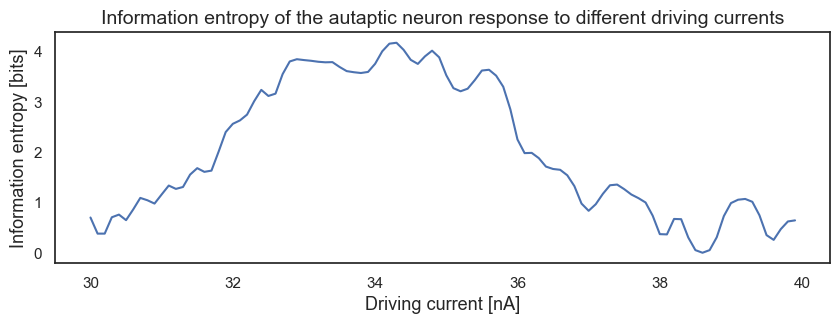

In [4]:
# See the information contained in the ISI distributions for fixed injected currents
H_isi = np.zeros(len(I_vals))

for n, i in enumerate(I_vals):
    counts = df[df['I_ext'] == i]['ISI_counts'].to_numpy()
    probs = counts/np.sum(counts)
    H_isi[n] = entropy(probs)

H_isi = gaussian_filter(H_isi, sigma = 1.0)

fig2, ax2 = plt.subplots(figsize = (10, 3))
plt.plot(I_vals, H_isi, c = 'b')
plt.title("Information entropy of the autaptic neuron response to different driving currents", fontsize = 14)
plt.ylabel("Information entropy [bits]", fontsize = 13)
plt.xlabel("Driving current [nA]", fontsize = 13)
plt.savefig(f"autaptic_information_{name}.png")